In [8]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
from glob import glob
import cv2
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Model
import tensorflow.keras.backend as K
from tqdm import tqdm
import time
from keras.layers import Cropping2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Add, Activation, Lambda

In [9]:
# Set parameters
batch_size = 4
lr = 1e-3
epochs = 100
width = 512
height = 512

In [10]:
dataset_path = os.path.join("/kaggle/input/uavid-v1")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [11]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "uavid_train","seq1", "Images", "*")))
    train_y = sorted(glob(os.path.join(path, "uavid_train","seq1", "Labels", "*")))

    valid_x = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Images", "*")))
    valid_y = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Labels", "*")))

    return (train_x, train_y), (valid_x, valid_y)

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [13]:
color_map = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building
    (128, 64, 128): 2,    # Road
    (0, 128, 0): 3,       # Tree
    (128, 128, 0): 4,     # Low vegetation
    (64, 0, 128): 5,      # Moving car
    (192, 0, 192): 6,     # Static car
    (64, 64, 0): 7        # Human
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)  # Read as a color image (BGR format)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

    # Create a blank mask to hold class indices
    class_indices = np.zeros((height, width), dtype=np.uint8)

    # Map each RGB value to the corresponding class index
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx

    return class_indices.astype(np.uint8) 

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)  # Image as float32
        y = read_mask(y)   # Mask as class indices
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.uint8]) 
    x.set_shape([height, width, 3]) 
    y.set_shape([height, width])   
    return x, y

In [15]:
def tf_dataset(x, y, batch=10):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:
from sklearn.model_selection import train_test_split

# Load dataset
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

# Split training set to get 500 for training and 100 for validation
train_x, additional_valid_x, train_y, additional_valid_y = train_test_split(
    train_x, train_y, test_size=100, random_state=42
)

# Combine 100 images from the training set with the existing validation set
valid_x = np.concatenate([valid_x, additional_valid_x], axis=0)
valid_y = np.concatenate([valid_y, additional_valid_y], axis=0)


print(f"New Train: {len(train_x)} - {len(train_y)}")
print(f"New Valid: {len(valid_x)} - {len(valid_y)}")


train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

Train: 600 - 600
Valid: 70 - 70
New Train: 500 - 500
New Valid: 170 - 170


In [17]:
class SelfAttention(layers.Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.key_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.value_dense = layers.Conv2D(embed_dim, kernel_size=1)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = inputs.shape[-1]  # Keep channels as a static dimension to avoid shape issues

        # Compute Q, K, V matrices
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Reshape for attention calculation
        query_flattened = tf.reshape(query, (batch_size, height * width, -1))
        key_flattened = tf.reshape(key, (batch_size, height * width, -1))
        value_flattened = tf.reshape(value, (batch_size, height * width, -1))

        # Attention Scores (scaled dot-product): Q * K^T / sqrt(d_k)
        score = tf.matmul(query_flattened, key_flattened, transpose_b=True)
        score = score / tf.math.sqrt(tf.cast(tf.shape(key_flattened)[-1], tf.float32))

        # Apply softmax to get attention weights
        attention_weights = self.softmax(score)

        # Multiply attention weights with values
        attention_output = tf.matmul(attention_weights, value_flattened)

        # Reshape back to original input shape
        attention_output = tf.reshape(attention_output, (batch_size, height, width, inputs.shape[-1]))
    
        # Combine input with attention output
        output = inputs + attention_output
        return output

In [18]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [24]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    attention_block = SelfAttention(embed_dim=64)(x) # Apply SAM
    p = MaxPool2D((2, 2))(x)
    return x, p

In [25]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    
    crop_height = max(0, x.shape[1] - skip.shape[1])
    crop_width = max(0, x.shape[2] - skip.shape[2])
    if crop_height > 0 or crop_width > 0:
        skip = Cropping2D(((crop_height // 2, crop_height // 2), (crop_width // 2, crop_width // 2)))(skip)
    
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    attention_block = SelfAttention(embed_dim=64)(x) # Apply SAM
    return x

In [26]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    b1 = conv_block(b1, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(8, (2, 2), padding="same", activation="softmax")(d4)
    model = Model(inputs, outputs, name='UNET_BAM')
    return model

In [27]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [28]:
model.summary()

Model: "UNET_BAM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_13[0][0] 

 Total params: 49,941,896 (190.51 MB)

 Trainable params: 49,926,024 (190.45 MB)

 Non-trainable params: 15,872 (62.00 KB)

In [29]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["acc"])

In [30]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [31]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1730022433.312320      94 service.cc:145] XLA service 0x7b3784003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730022433.312387      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1730022435.484180      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1730022473.626550      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - acc: 0.5074 - loss: 1.3041

W0000 00:00:1730022561.482540      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1730022588.741402      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 32.86675, saving model to files/modified_uavid_dataset/UnetModel.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 996ms/step - acc: 0.5077 - loss: 1.3030 - val_acc: 0.1153 - val_loss: 32.8668 - learning_rate: 0.0010
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - acc: 0.6123 - loss: 1.0045
Epoch 2: val_loss improved from 32.86675 to 14.18032, saving model to files/modified_uavid_dataset/UnetModel.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 869ms/step - acc: 0.6124 - loss: 1.0044 - val_acc: 0.0769 - val_loss: 14.1803 - learning_rate: 0.0010
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - acc: 0.6471 - loss: 0.9211
Epoch 3: val_loss improved from 14.18032 to 5.91415, saving model to files/modified_uavid_dataset/UnetModel.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 870ms/step - acc: 0.6472 - loss: 0.9210 - val_acc: 0.2051 - val_loss: 5.9142 - learning_rate: 0.0010
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - acc: 0.6641 - loss: 0.8696
E

In [33]:
datasetpath = "/kaggle/input/uavid-v1/uavid_test"
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [34]:
custom_objects = {
    "custom_SAM": SelfAttention,
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

Index(['epoch', 'acc', 'learning_rate', 'loss', 'val_acc', 'val_loss'], dtype='object')


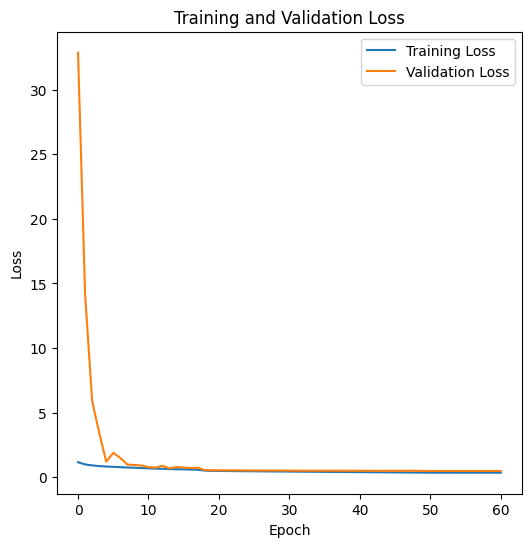

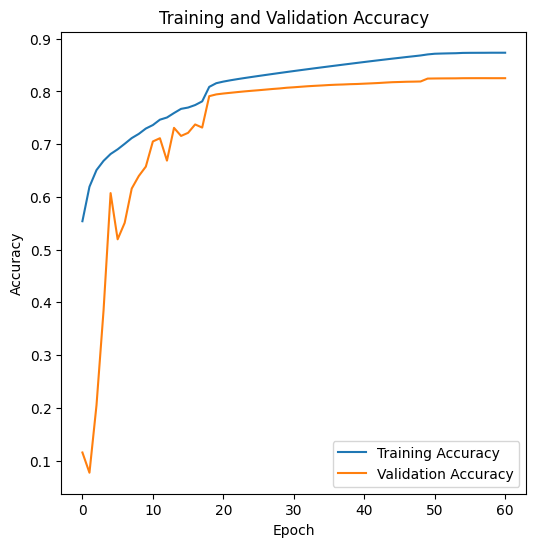

In [35]:
import matplotlib.pyplot as plt
import os
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)

# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path) # Close the figure to free memory
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['acc'], label='Training Accuracy')
plt.plot(log_data['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

In [36]:
test_x = sorted(glob(os.path.join(dataset_path, "uavid_test", "*", "Images", "*")))
print(f"Test: {len(test_x)}")

Test: 150


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


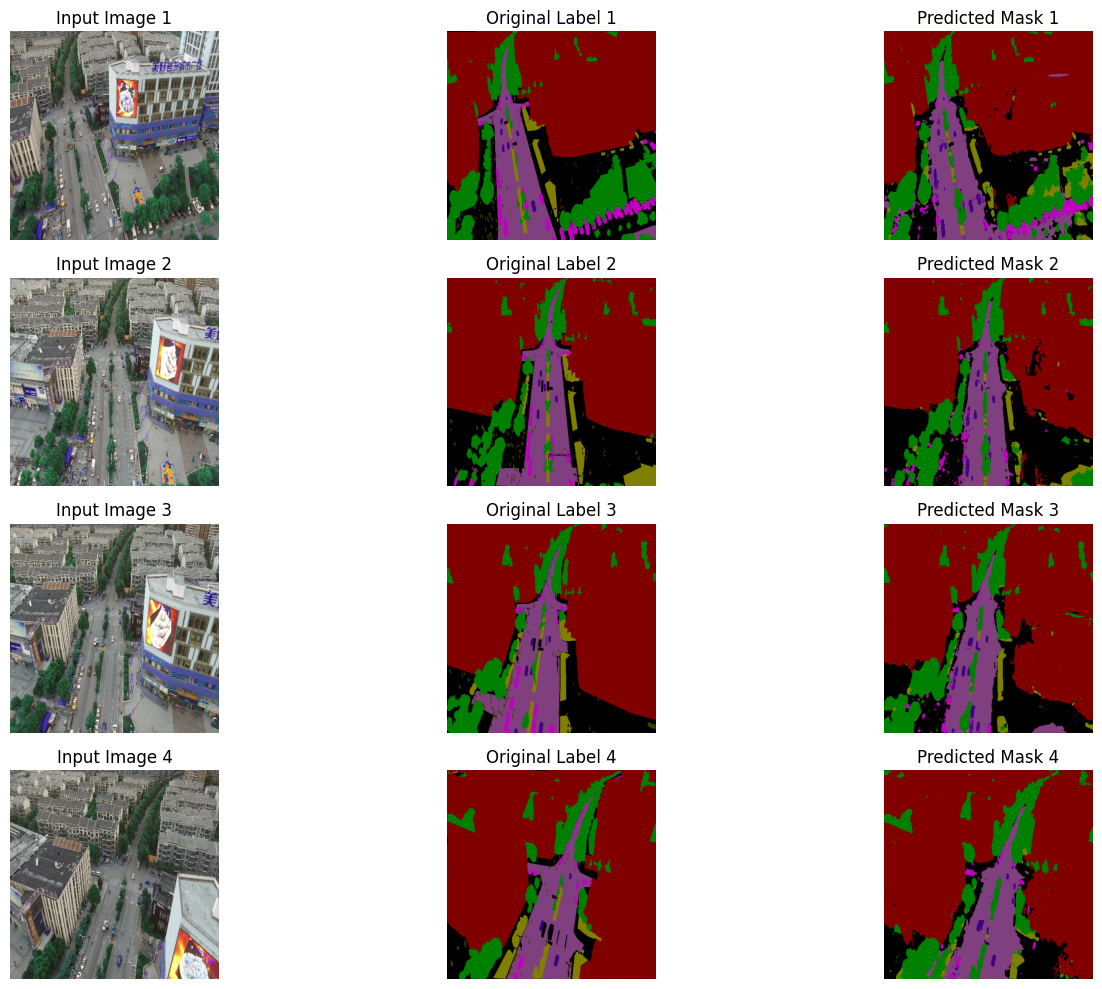

In [37]:
import matplotlib.colors as mcolors

# Define image dimensions
width = 512
height = 512

# Define RGB to class index mapping
rgb_to_class = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building (Red)
    (128, 64, 128): 2,    # Road (Purple)
    (0, 128, 0): 3,       # Tree (Green)
    (128, 128, 0): 4,     # Low vegetation (Yellow)
    (64, 0, 128): 5,      # Moving car (Purple-blue)
    (192, 0, 192): 6,     # Static car (Pink)
    (64, 64, 0): 7        # Human (Dark Yellow)
}

# Reverse mapping to go from class indices to RGB
class_to_rgb = {v: k for k, v in rgb_to_class.items()}

# Normalize RGB values for use in the colormap
class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

# Function to map class indices back to RGB colors
def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask

# Prediction code
plt.figure(figsize=(15, 10))  # Adjust size to fit 4 images comfortably

# Take a batch of images and masks from the validation dataset
batch = next(iter(valid_dataset))  # Fetch the next batch from the dataset
batch_x, batch_y = batch

# Ensure we process all images in the batch
num_images = batch_x.shape[0]

for i in range(num_images):
    # Extract images and masks
    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()

    # Model prediction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # Predict for a single image
    predicted_class_indices = np.argmax(prediction, axis=-1)  # Convert softmax output to class indices

    # Map predicted class indices to RGB
    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    # Load the original label image for comparison
    original_label_path = valid_y[i]  # Make sure `valid_y` has the correct paths
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    # Plot the images
    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [38]:
time_taken = []
for x in tqdm(test_x):
    # Extract sequence folder and image name
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    # Read and preprocess the image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Predict and measure time
    start_time = time.time()
    p = model.predict(x)[0]  # Remove batch dimension
    total_time = time.time() - start_time
    time_taken.append(total_time)

    # Convert softmax output to class indices
    p_class_indices = np.argmax(p, axis=-1)  # Convert to a single-channel mask of class indices
    
    # Map class indices back to RGB colors using the color map
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    # Correctly map class indices to RGB colors
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb  # Map class index to corresponding RGB value
    
    # Ensure it's in RGB before saving
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    # Save the mask as an RGB image, including the sequence folder in the name
    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 1/150 [00:00<00:59,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 2/150 [00:00<00:58,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 3/150 [00:01<00:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 4/150 [00:01<00:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 5/150 [00:01<00:55,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 6/150 [00:02<00:54,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▍         | 7/150 [00:02<00:54,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 8/150 [00:03<00:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 9/150 [00:03<00:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 10/150 [00:03<00:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 11/150 [00:04<00:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|▊         | 12/150 [00:04<00:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▊         | 13/150 [00:04<00:53,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 14/150 [00:05<00:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 15/150 [00:05<00:53,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 16/150 [00:06<00:52,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 17/150 [00:06<00:53,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 18/150 [00:06<00:52,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 19/150 [00:07<00:52,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 20/150 [00:07<00:52,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 21/150 [00:08<00:51,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 22/150 [00:08<00:50,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 23/150 [00:08<00:49,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 24/150 [00:09<00:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 25/150 [00:09<00:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█▋        | 26/150 [00:10<00:47,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 27/150 [00:10<00:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▊        | 28/150 [00:10<00:49,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 29/150 [00:11<00:49,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 30/150 [00:11<00:48,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 31/150 [00:12<00:48,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██▏       | 32/150 [00:12<00:49,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 33/150 [00:13<00:48,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 34/150 [00:13<00:46,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 35/150 [00:13<00:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 36/150 [00:14<00:45,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▍       | 37/150 [00:14<00:44,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 38/150 [00:14<00:44,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 39/150 [00:15<00:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 40/150 [00:15<00:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 41/150 [00:16<00:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 42/150 [00:16<00:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▊       | 43/150 [00:16<00:42,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 44/150 [00:17<00:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 45/150 [00:17<00:41,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 46/150 [00:18<00:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███▏      | 47/150 [00:18<00:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 48/150 [00:18<00:41,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 49/150 [00:19<00:40,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 50/150 [00:19<00:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 51/150 [00:20<00:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 52/150 [00:20<00:40,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▌      | 53/150 [00:20<00:40,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 54/150 [00:21<00:39,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 55/150 [00:21<00:38,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 56/150 [00:22<00:37,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 57/150 [00:22<00:36,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 58/150 [00:22<00:36,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|███▉      | 59/150 [00:23<00:35,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|████      | 60/150 [00:23<00:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 61/150 [00:24<00:34,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████▏     | 62/150 [00:24<00:34,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 63/150 [00:24<00:35,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 64/150 [00:25<00:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 65/150 [00:25<00:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 66/150 [00:26<00:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 67/150 [00:26<00:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 68/150 [00:26<00:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 69/150 [00:27<00:35,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 70/150 [00:27<00:34,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 71/150 [00:28<00:33,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 72/150 [00:28<00:32,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 73/150 [00:29<00:32,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 74/150 [00:29<00:32,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 75/150 [00:29<00:31,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 76/150 [00:30<00:31,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████▏    | 77/150 [00:30<00:30,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 78/150 [00:31<00:30,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 79/150 [00:31<00:29,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 80/150 [00:32<00:29,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 81/150 [00:32<00:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 82/150 [00:32<00:30,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 83/150 [00:33<00:29,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 84/150 [00:33<00:28,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 85/150 [00:34<00:28,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 86/150 [00:34<00:27,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 87/150 [00:35<00:27,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▊    | 88/150 [00:35<00:27,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 89/150 [00:35<00:26,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 90/150 [00:36<00:26,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 61%|██████    | 91/150 [00:36<00:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 92/150 [00:37<00:25,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 93/150 [00:37<00:24,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 94/150 [00:38<00:23,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 95/150 [00:38<00:23,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 96/150 [00:38<00:22,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 97/150 [00:39<00:22,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 98/150 [00:39<00:22,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████▌   | 99/150 [00:40<00:21,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 100/150 [00:40<00:21,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 101/150 [00:41<00:20,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 102/150 [00:41<00:20,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▊   | 103/150 [00:41<00:19,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 104/150 [00:42<00:19,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|███████   | 105/150 [00:42<00:20,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 106/150 [00:43<00:19,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████▏  | 107/150 [00:43<00:19,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 108/150 [00:44<00:18,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 109/150 [00:44<00:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 110/150 [00:45<00:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 111/150 [00:45<00:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 112/150 [00:45<00:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 113/150 [00:46<00:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 114/150 [00:46<00:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 115/150 [00:46<00:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 116/150 [00:47<00:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 117/150 [00:47<00:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▊  | 118/150 [00:47<00:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 119/150 [00:48<00:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 120/150 [00:48<00:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 121/150 [00:48<00:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████▏ | 122/150 [00:49<00:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 123/150 [00:49<00:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 124/150 [00:50<00:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 125/150 [00:50<00:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 126/150 [00:50<00:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 127/150 [00:51<00:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 128/150 [00:51<00:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 129/150 [00:51<00:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 130/150 [00:52<00:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 131/150 [00:52<00:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 132/150 [00:52<00:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▊ | 133/150 [00:53<00:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 134/150 [00:53<00:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 135/150 [00:54<00:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 136/150 [00:54<00:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████▏| 137/150 [00:54<00:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 138/150 [00:55<00:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 139/150 [00:55<00:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 140/150 [00:55<00:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 141/150 [00:56<00:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 142/150 [00:56<00:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 143/150 [00:57<00:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 144/150 [00:57<00:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 145/150 [00:57<00:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 146/150 [00:58<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 147/150 [00:58<00:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▊| 148/150 [00:58<00:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 149/150 [00:59<00:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 150/150 [00:59<00:00,  2.51it/s]


In [39]:
mean_time = np.mean(time_taken)
print(f"Mean time taken: {mean_time}")
mean_fps = 1/mean_time
print(f"Mean FPS: {mean_fps}")

Mean time taken: 0.10627552191416423
Mean FPS: 9.409504484086863


In [40]:
!zip -r sam.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'sam.zip')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_accuracy.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_loss.png (deflated 13%)
  adding: kaggle/working/files/modified_uavid_dataset/UnetModel.keras (deflated 7%)
  adding: kaggle/working/files/modified_uavid_dataset/Log-Unet.csv (deflated 59%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq22_000400.png (deflated 15%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq27_000000.png (deflated 16%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq29_000400.png (deflated 11%)
  adding: kaggle/working/Predictio

/kaggle/working/sam.zip